In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

In [2]:
paradigm = 'FLA'
beh_dir_path = f'data/BEH_{paradigm}'

In [3]:
all_behavioral_data_df = pd.DataFrame()

id_list = [item.split('.')[0] for item in os.listdir(beh_dir_path)]
for participant_id  in id_list:
    behavioral_df = pd.read_csv(f'{beh_dir_path}/{participant_id}.csv')
    behavioral_df['ID'] = participant_id.split("_")[1]
    all_behavioral_data_df = pd.concat([all_behavioral_data_df, behavioral_df], ignore_index=True)

## Stats

In [4]:
columns = ['ID', 'trial_type', 'rt', 'reaction']

all_behavioral_data_df = all_behavioral_data_df[all_behavioral_data_df['block_type'] == 'experiment']
all_behavioral_data_df['trial_reaction'] = (
        all_behavioral_data_df['trial_type'].astype(str) + '_' + all_behavioral_data_df['reaction'])

### Participant-leval stats

In [58]:
participant_level_stats = (
    all_behavioral_data_df[columns].groupby(['ID', 'trial_type', 'reaction', ]).describe())
display(participant_level_stats)

participant_level_stats.to_csv('data/participant_level_stats.csv')

rt                                          \
                               count      mean       std       min       25%   
ID      trial_type  reaction                                                   
FLA-000 congruent   correct    210.0  0.223956  0.026446  0.143648  0.210209   
        incongruent correct     49.0  0.337103  0.058630  0.243454  0.310262   
                    incorrect   41.0  0.208280  0.017890  0.160392  0.193718   
FLA-001 congruent   correct    210.0  0.257862  0.026052  0.194533  0.243250   
        incongruent correct     64.0  0.390750  0.056233  0.313173  0.352640   
...                              ...       ...       ...       ...       ...   
FLA-223 incongruent correct     69.0  0.365533  0.047319  0.278267  0.344986   
                    incorrect   21.0  0.239578  0.030318  0.190915  0.215672   
FLA-224 congruent   correct    210.0  0.254322  0.040785  0.171974  0.229703   
        incongruent correct     65.0  0.362354  0.071438  0.266412  0.315675   
                    incorrect   24.0  0.229557  0.022964  0.173861  0.221070   

                                                             
                                    50%       75%       max  
ID      trial_type  reaction                                 
FLA-000 congruent   correct    0.226925  0.243615  0.310328  
        incongruent correct    0.326854  0.360046  0.643885  
                    incorrect  0.210205  0.226772  0.243661  
FLA-001 congruent   correct    0.257388  0.271272  0.354280  
        incongruent correct    0.379367  0.410341  0.618896  
...                                 ...       ...       ...  
FLA-223 incongruent correct    0.357457  0.380038  0.611504  
                    incorrect  0.232920  0.266973  0.299015  
FLA-224 congruent   correct    0.248382  0.271444  0.525692  
        incongruent correct    0.345617  0.384703  0.618361  
                    incorrect  0.233016  0.242058  0.264286  

[826 rows x 8 columns]

Calculate accuracy stats

In [5]:
df = all_behavioral_data_df
grouped_df = df[columns].groupby(['ID'])
participants_congruent_acc = []
participants_incongruent_acc = []

for group_name, group_data in grouped_df:
    inner_group = group_data.groupby(['trial_type', 'reaction'])
    for inner_group_name, inner_group_data in inner_group:
        incongruent_correct = inner_group.get_group(('incongruent', 'correct')).count()["rt"]
        congruent_correct = inner_group.get_group(('congruent', 'correct')).count()["rt"]
        incongruent_incorrect = inner_group.get_group(('incongruent', 'incorrect')).count()["rt"]
        try:
            congruent_incorrect = inner_group.get_group(('congruent', 'incorrect')).count()["rt"]
        except:
            congruent_incorrect = 0

        congruent_acc = congruent_correct / (congruent_correct + congruent_incorrect)
        participants_congruent_acc.append(congruent_acc)
        incongruent_acc = incongruent_correct / (incongruent_correct + incongruent_incorrect)
        participants_incongruent_acc.append(incongruent_acc)

Plot RT distributions

<Figure size 20000x50000 with 0 Axes>

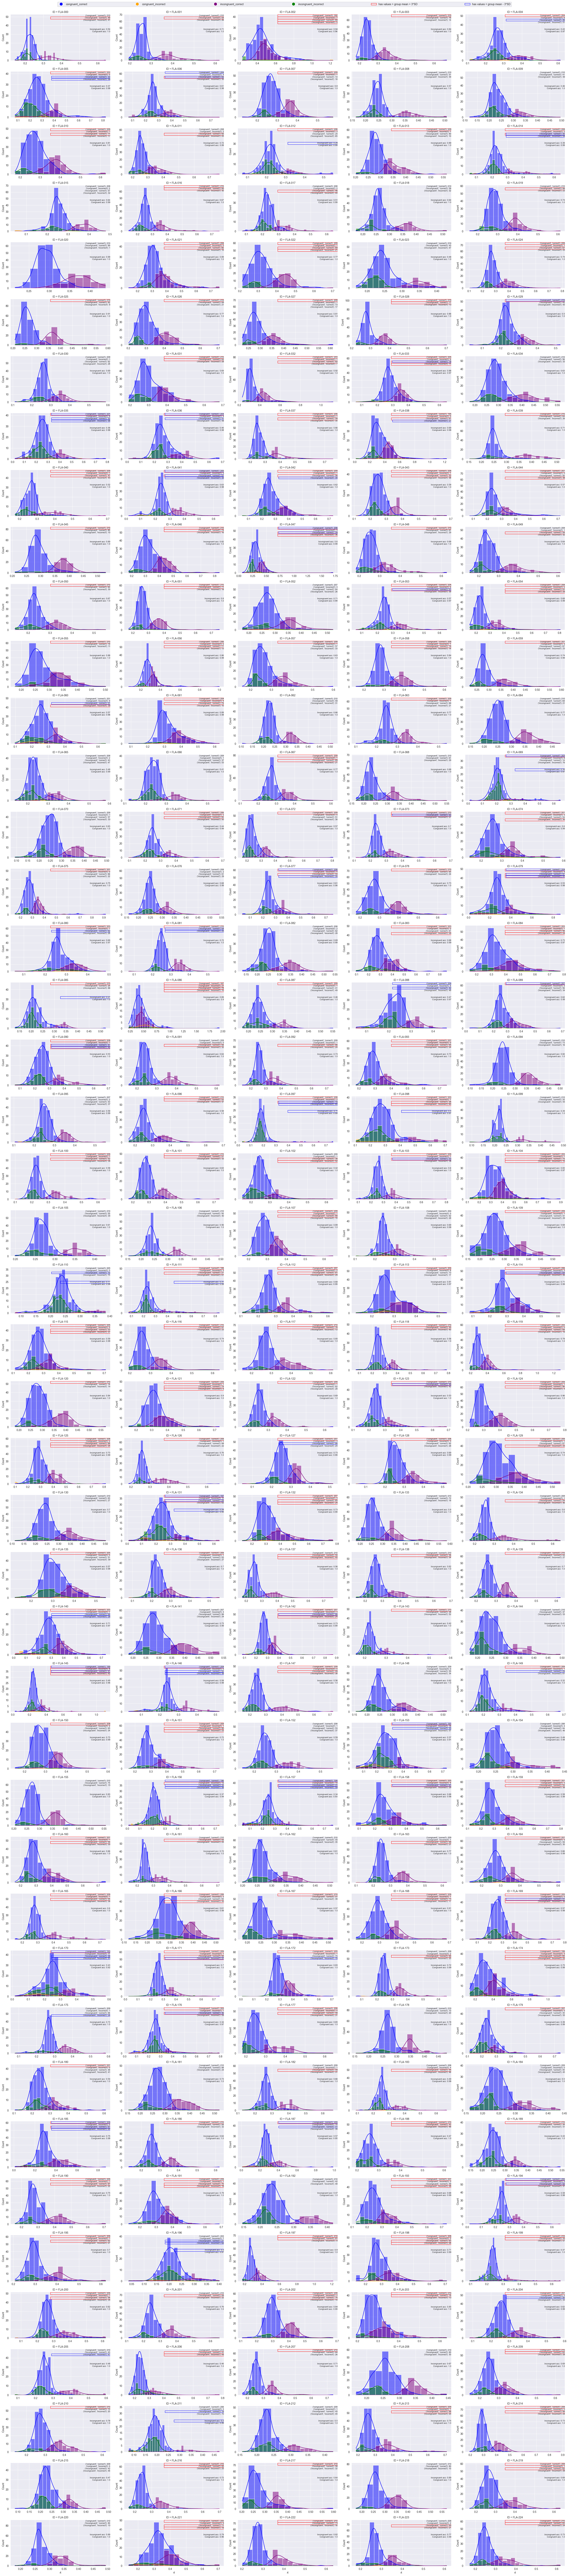

In [9]:
plt.figure(figsize=(200,500))
plt.rcParams['savefig.dpi'] = 300

hue_palette = {
    "congruent_correct": "blue", 
    "congruent_incorrect": "orange", 
    "incongruent_correct": "purple",
    "incongruent_incorrect": "green"
}

hue_order = [
    "incongruent_correct", 
    "incongruent_incorrect", 
    "congruent_correct", 
    "congruent_incorrect"
]

df = all_behavioral_data_df

g = sns.FacetGrid(
    df.sort_values(['ID', 'trial_reaction']), 
    col="ID", 
    col_wrap=5, 
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot, 
    x="rt", 
    kde=True,
    palette=hue_palette,
    hue='trial_reaction',
    hue_order=hue_order,
    
)

# g.set(xlim=(0,1))

# Add annotations to each facet

grouped_df = df[columns].groupby(['ID'])
wide = 3
group_level_agg_df = all_behavioral_data_df[columns].groupby(['trial_type', 'reaction']).agg(
    {
        'rt': ["count", "mean", "std", "min", "max"]
    }
)
       
for ax, (group_name, group_data) in zip(g.axes.flat, grouped_df):
    inner_group = group_data.groupby(['trial_type', 'reaction'])
    offset = 0
    for inner_group_name, inner_group_data in inner_group:
        ax.annotate(f'{inner_group_name}: {inner_group_data.count()["rt"]}', xy=(1, 1 - offset), 
                    xycoords='axes fraction', ha='right', va='top', fontsize=8)
        if (inner_group_data['rt'] > group_level_agg_df.loc[inner_group_name]['rt', 'mean'] +
            wide * group_level_agg_df.loc[inner_group_name]['rt', 'std']).any():
    
            frame = patches.Rectangle((0.4, 0.95 - offset), 0.6, 0.05, linewidth=1, edgecolor='red', facecolor='none', transform=ax.transAxes)
            ax.add_patch(frame)

        if (inner_group_data['rt'] < group_level_agg_df.loc[inner_group_name]['rt', 'mean'] -
            wide * group_level_agg_df.loc[inner_group_name]['rt', 'std']).any():

            frame = patches.Rectangle((0.41, 0.96 - offset), 0.59, 0.04, linewidth=1, edgecolor='blue', facecolor='none', transform=ax.transAxes)
            ax.add_patch(frame)

        offset += 0.05


    incongruent_correct = inner_group.get_group(('incongruent', 'correct')).count()["rt"]
    congruent_correct = inner_group.get_group(('congruent', 'correct')).count()["rt"]
    incongruent_incorrect = inner_group.get_group(('incongruent', 'incorrect')).count()["rt"]
    try:
        congruent_incorrect = inner_group.get_group(('congruent', 'incorrect')).count()["rt"]
    except:
        congruent_incorrect = 0

    ax.annotate(f'Incongruent acc: {round(incongruent_correct/(incongruent_incorrect + incongruent_correct), 2)}', xy=(1, 0.7), xycoords='axes fraction', ha='right', va='top', fontsize=8)

    ax.annotate(f'Congruent acc: {round(congruent_correct/(congruent_incorrect+congruent_correct), 2)}', xy=(1, 0.65), xycoords='axes fraction', ha='right', va='top', fontsize=8)

    if incongruent_correct/(incongruent_incorrect + incongruent_correct) <  (np.mean(participants_incongruent_acc) - 2 * np.std(participants_incongruent_acc)):

        frame = patches.Rectangle((0.5, 0.65), 0.6, 0.05, linewidth=1, edgecolor='blue', facecolor='none', transform=ax.transAxes)
        # Add the Rectangle patch to the plot
        ax.add_patch(frame)

    
# Define custom colors and labels
custom_colors = hue_palette
custom_labels = list(custom_colors.keys())

# Manually create a custom legend
legend_elements = [
    plt.Line2D(
        [0], 
        [0], 
        marker='o', 
        color='w', 
        markerfacecolor=custom_colors[label], 
        markersize=12, 
        label=label
    ) 
    for label in custom_labels
]

rectangle_patch_red = patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='red')
rectangle_patch_blue = patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='blue')
legend_elements.append(rectangle_patch_red)
custom_labels.append('has values > group mean + 3*SD')
legend_elements.append(rectangle_patch_blue)
custom_labels.append('has values < group mean - 3*SD')

# Get the figure and add the legend above the FacetGrid
fig = plt.gcf()

fig.legend(
    handles=legend_elements, 
    title=None,  
    bbox_to_anchor=(0.1, 1 ,0.8,-1), 
    loc='lower right', 
    ncol=6, 
    mode='expand', 
    labels=custom_labels
)

plt.savefig('test.png', bbox_inches='tight')
# plt.show()

### Group-level stats

#### With participant-level aggregation


In [29]:
df = all_behavioral_data_df

participant_level_stats = (
    all_behavioral_data_df[columns].groupby(['ID', 'trial_type', 'reaction', ]).describe())

group_level_participant_agg_df = participant_level_stats.groupby(['trial_type', 'reaction']).agg(
    {
        ('rt', 'mean'): ["count", "mean", "std"],
        ('rt', 'std'): ["mean", "std"],
        ('rt', 'min'): ["mean", "std",],
        ('rt', 'max'): ["mean", "std",]
    })

grouped_df = df[columns].groupby(['ID'])
participants_congruent_acc = []
participants_incongruent_acc = []
participants_overall_acc = []

for group_name, group_data in grouped_df:
    # group_data = grouped_df[1]
    inner_group = group_data.groupby(['trial_type', 'reaction'])
    for inner_group_name, inner_group_data in inner_group:
        incongruent_correct = inner_group.get_group(('incongruent', 'correct')).count()["rt"]
        congruent_correct = inner_group.get_group(('congruent', 'correct')).count()["rt"]
        incongruent_incorrect = inner_group.get_group(('incongruent', 'incorrect')).count()["rt"]
        try:
            congruent_incorrect = inner_group.get_group(('congruent', 'incorrect')).count()["rt"]
        except:
            congruent_incorrect = 0

        congruent_acc = congruent_correct / (congruent_correct + congruent_incorrect)
        participants_congruent_acc.append(congruent_acc)
        incongruent_acc = incongruent_correct / (incongruent_correct + incongruent_incorrect)
        participants_incongruent_acc.append(incongruent_acc)
        overall_acc = (congruent_correct + incongruent_correct) / (congruent_correct + congruent_incorrect + incongruent_correct + incongruent_incorrect)
        participants_overall_acc.append(overall_acc)
        

display(group_level_participant_agg_df)
group_level_participant_agg_df.to_csv('group_level_participant_aggregated_rt_stats.csv')

print(f'Congruent accuracy: {np.mean(participants_congruent_acc):.2f} ({np.std(participants_congruent_acc):.2f})')
print(f'Incongruent accuracy: {np.mean(participants_incongruent_acc):.2f} ({np.std(participants_incongruent_acc):.2f})')
print(f'Overall accuracy: {np.mean(participants_overall_acc):.2f} ({np.std(participants_overall_acc):.2f})')

rt                                                    \
                       mean                           std                 min   
                      count      mean       std      mean       std      mean   
trial_type  reaction                                                            
congruent   correct     225  0.266978  0.033100  0.052014  0.022268  0.141035   
            incorrect   137  0.222918  0.100562  0.076789  0.057019  0.174405   
incongruent correct     225  0.373722  0.035786  0.064339  0.024502  0.243156   
            incorrect   225  0.234955  0.026614  0.038522  0.026030  0.157425   

                                                     
                                      max            
                            std      mean       std  
trial_type  reaction                                 
congruent   correct    0.051624  0.570705  0.205606  
            incorrect  0.105491  0.287017  0.163982  
incongruent correct    0.084608  0.603705  0.117148  
            incorrect  0.048727  0.328874  0.091351

Congruent accuracy: 0.99 (0.02)
Incongruent accuracy: 0.64 (0.17)
Overall accuracy: 0.88 (0.05)


In [30]:
df = all_behavioral_data_df
grouped_df = df[columns].groupby(['ID'])
acc_df = pd.DataFrame()

for group_name, group_data in grouped_df:
    inner_group = group_data.groupby(['trial_type', 'reaction'])
    for inner_group_name, inner_group_data in inner_group:
        incongruent_correct = inner_group.get_group(('incongruent', 'correct')).count()["rt"]
        congruent_correct = inner_group.get_group(('congruent', 'correct')).count()["rt"]
        incongruent_incorrect = inner_group.get_group(('incongruent', 'incorrect')).count()["rt"]
        try:
            congruent_incorrect = inner_group.get_group(('congruent', 'incorrect')).count()["rt"]
        except:
            congruent_incorrect = 0

        congruent_acc = congruent_correct / (congruent_correct + congruent_incorrect)
        incongruent_acc = incongruent_correct / (incongruent_correct + incongruent_incorrect)
        overall_acc = (congruent_correct + incongruent_correct) / (congruent_correct + congruent_incorrect + incongruent_correct + incongruent_incorrect)
        participants_overall_acc.append(overall_acc)

        this_results = pd.DataFrame({
            'ID': [group_name[0]],
            'accuracy': 'congruent',
            'value': [congruent_acc],
        })

        acc_df = pd.concat([acc_df, this_results], ignore_index=True)

        this_results = pd.DataFrame({
            'ID': [group_name[0]],
            'accuracy': 'incongruent',
            'value': [incongruent_acc],
        })

        acc_df = pd.concat([acc_df, this_results], ignore_index=True)

        this_results = pd.DataFrame({
            'ID': [group_name[0]],
            'accuracy': 'overall',
            'value': [overall_acc],
        })

        acc_df = pd.concat([acc_df, this_results], ignore_index=True)

<Figure size 2400x1000 with 0 Axes>

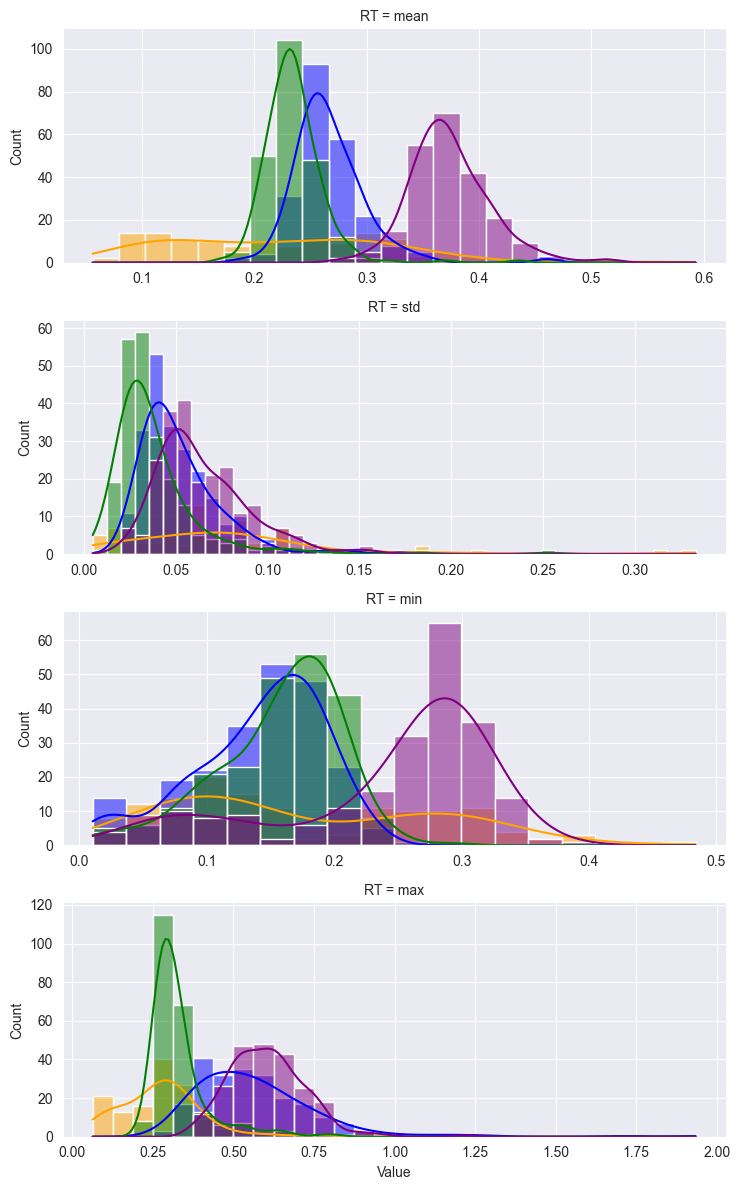

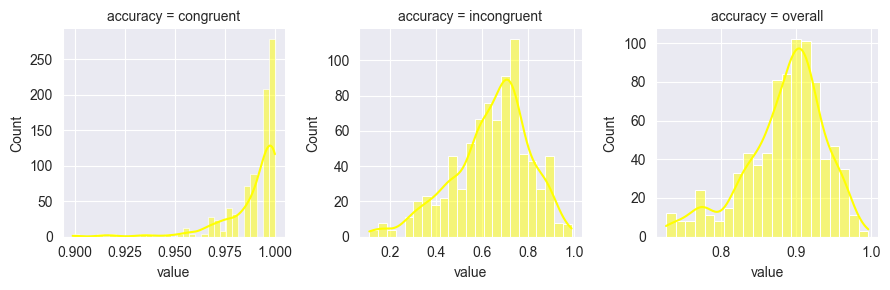

In [33]:
plt.figure(figsize=(24,10))
plt.rcParams['savefig.dpi'] = 300


participant_level_stats = all_behavioral_data_df.groupby(['ID', 'trial_reaction'])['rt'].describe()
melted_df = participant_level_stats.reset_index()[['ID', 'trial_reaction', 'mean', 'std', 'min', 'max']]
melted_df = pd.melt(melted_df, id_vars=['ID', 'trial_reaction'], var_name='RT', value_name='Value')

hue_palette = {
    "congruent_correct": "blue",
    "congruent_incorrect": "orange",
    "incongruent_correct": "purple",
    "incongruent_incorrect": "green"
}

hue_order = ["incongruent_correct", "incongruent_incorrect", "congruent_correct", "congruent_incorrect"]

g1 = sns.FacetGrid(
    melted_df.sort_values(['ID', 'trial_reaction']),
    col="RT",
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=2.5
)

g1.map_dataframe(
    sns.histplot,
    x="Value",
    kde=True,
    palette=hue_palette,
    hue='trial_reaction',
    hue_order=hue_order,
)


g2 = sns.FacetGrid(
    acc_df.sort_values(['ID']),
    col="accuracy",
    col_wrap=3,
    sharex=False,
    sharey=False,
)

g2.map_dataframe(
    sns.histplot,
    x="value",
    kde=True,
    color='yellow',
)

# Define custom colors and labels
custom_colors = hue_palette
custom_labels = list(custom_colors.keys())

# Manually create a custom legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker='o',
        color='w',
        markerfacecolor=custom_colors[label],
        markersize=12,
        label=label
    )
    for label in custom_labels
]

# Get the figure and add the legend above the FacetGrid
# fig = plt.gcf()
# 
# fig.legend(
#     handles=legend_elements,
#     title=None,
#     bbox_to_anchor=(0.1, 1 ,0.8 ,-1),
#     loc='lower right',
#     ncol=2,
#     mode='expand'
# )

plt.savefig('participants_aggregated_stats_acc_distributions.png', bbox_inches='tight')
plt.show()

#### No participant-level aggregation

In [34]:
# RTs
group_level_agg_df = all_behavioral_data_df[columns].groupby(['reaction', 'trial_type']).agg(
    {
        'rt': ["count", "mean", "std", "min", "max"]
    })

# accuracy
groups = all_behavioral_data_df[columns].groupby(['trial_type', 'reaction'])

incongruent_correct = groups.get_group(('incongruent', 'correct')).count()["rt"]
congruent_correct = groups.get_group(('congruent', 'correct')).count()["rt"]
incongruent_incorrect = groups.get_group(('incongruent', 'incorrect')).count()["rt"]
try:
    congruent_incorrect = groups.get_group(('congruent', 'incorrect')).count()["rt"]
except:
    congruent_incorrect = 0

congruent_acc = congruent_correct / (congruent_correct + congruent_incorrect)
incongruent_acc = incongruent_correct / (incongruent_correct + incongruent_incorrect)
overal_acc = (congruent_correct + incongruent_correct) / (congruent_correct + congruent_incorrect + incongruent_correct + incongruent_incorrect)

display(group_level_agg_df)
# group_level_agg_df.to_csv('group_level_rt_stats.csv')

print(f'In-group congruent accuracy: {congruent_acc:.2f}')
print(f'In-group incongruent accuracy: {incongruent_acc:.2f}')
print(f'In-group overall accuracy: {overal_acc:.2f}')

rt                                        
                       count      mean       std       min       max
reaction  trial_type                                                
correct   congruent    46634  0.266775  0.064801  0.010469  1.934271
          incongruent  12965  0.377038  0.074445  0.010613  1.215940
incorrect congruent      473  0.221616  0.145971  0.010512  1.229905
          incongruent   7191  0.228872  0.046785  0.010376  0.820181

In-group congruent accuracy: 0.99
In-group incongruent accuracy: 0.64
In-group overall accuracy: 0.89


RTs plot per condition

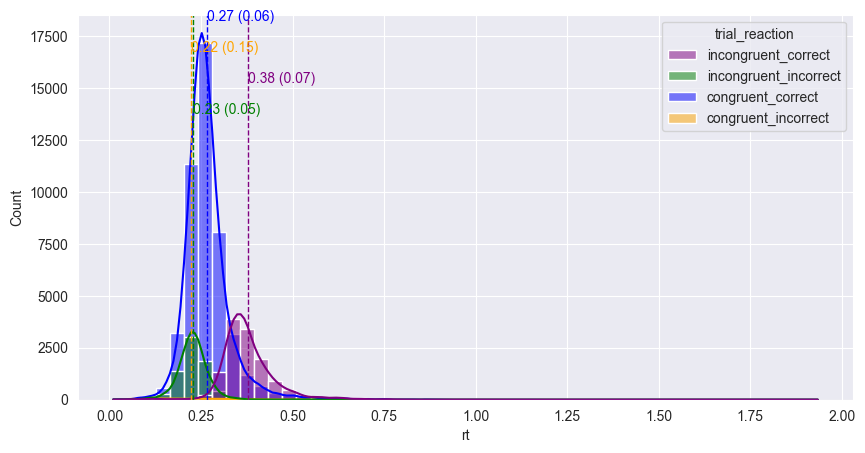

In [40]:
plt.figure(figsize=(10,5))
plt.rcParams['savefig.dpi'] = 300

hue_palette = {
    "congruent_correct": "blue",
    "congruent_incorrect": "orange",
    "incongruent_correct": "purple",
    "incongruent_incorrect": "green"
}

hue_order = ["incongruent_correct", "incongruent_incorrect", "congruent_correct", "congruent_incorrect"]


g = sns.histplot(
    all_behavioral_data_df,
    x="rt",
    kde=True,
    hue='trial_reaction',
    palette=hue_palette,
    hue_order=hue_order,
    bins=50,
)

# Calculate the means for each group in the hue
hue_means = all_behavioral_data_df.groupby('trial_reaction')['rt'].mean()
hue_stds = all_behavioral_data_df.groupby('trial_reaction')['rt'].std()

# Add vertical mean lines for each group
offset = 0
for (hue_value, mean_value), (hue_std_value, std_value) in zip(hue_means.items(), hue_stds.items()):
    color = hue_palette.get(hue_value, 'red')  # Use red if hue_value is not found in the dictionary

    plt.axvline(mean_value, color=color, linestyle='dashed', linewidth=1, label=f'Mean ({hue_value}): {mean_value:.2f}')
    ylim = plt.ylim()
    plt.text(mean_value, ylim[1] - 100 - offset, f'{mean_value:.2f} ({std_value:.2f})', color=color, va='center', ha='left', fontsize=10)
    offset += 1500

plt.savefig('group_level_rt_distributions_per_condition.png', bbox_inches='tight')
plt.show()

RT plot no condition separation

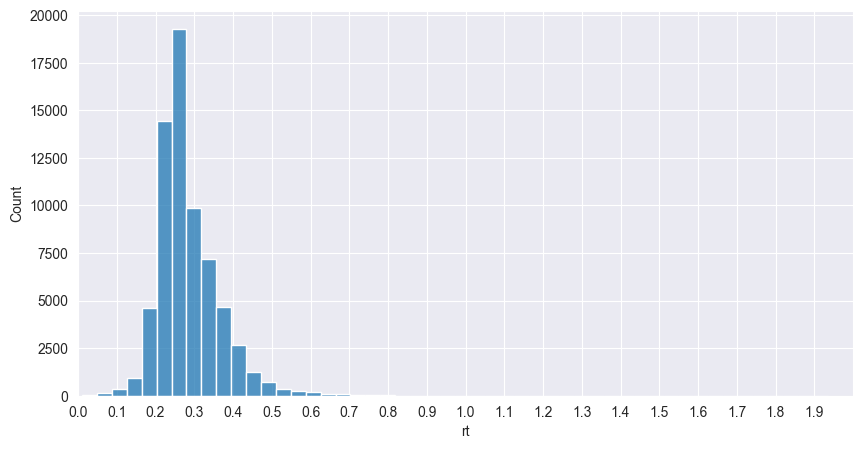

In [39]:
plt.figure(figsize=(10,5))
plt.rcParams['savefig.dpi'] = 300

hue_palette = {
    "congruent_correct": "blue",
    "congruent_incorrect": "orange",
    "incongruent_correct": "purple",
    "incongruent_incorrect": "green"
}

hue_order = ["incongruent_correct", "incongruent_incorrect", "congruent_correct", "congruent_incorrect"]


g = sns.histplot(
    all_behavioral_data_df,
    x="rt",
    # kde=True,
    # hue='trial_reaction',
    # palette=hue_palette,
    # hue_order=hue_order,
    bins=50,
    stat='count',
    # shrink=2,
)

g.set_xlim(0,2.0)
g.set_xticks(np.arange(0,2, 0.1))

plt.savefig('group_level_rt_distributions.png', bbox_inches='tight')
plt.show()

RT violinplot of conditions

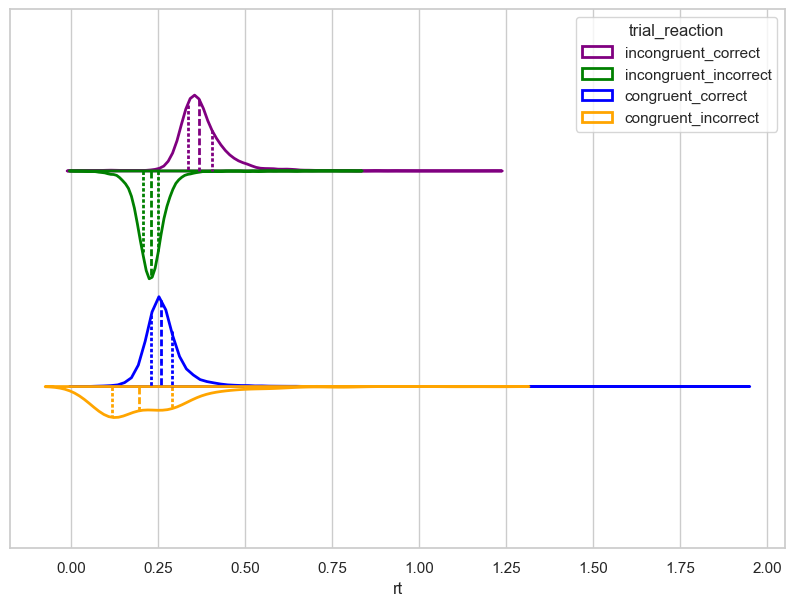

In [37]:
plt.figure(figsize=(10,7))
plt.rcParams['savefig.dpi'] = 500
sns.set_theme(style='whitegrid')

hue_palette = {
    "congruent_correct": "blue",
    "congruent_incorrect": "orange",
    "incongruent_correct": "purple",
    "incongruent_incorrect": "green"
}

hue_order = ["incongruent_correct", "incongruent_incorrect", "congruent_correct", "congruent_incorrect"]

g = sns.violinplot(
    all_behavioral_data_df,
    x="rt",
    # kde=True,
    hue='trial_reaction',
    palette=hue_palette,
    density_norm='area',
    common_norm=True,
    linewidth=2,
    inner='quart',
    split=True,
    hue_order=hue_order,
    fill=False,
)

plt.savefig('group_level_rt_distributions_violin.png', bbox_inches='tight')
# plt.show()